In [1]:
import datacube # Load the datacube library
import datetime
import numpy as np
import json
import matplotlib.pyplot as plt
from utils.utils import (
    lat_lon_to_epsg,
    three_band_image,
    load_config_extents,
    transform_to_wgs)

"""
index data into datacube from command line:
docker-compose exec jupyter bash -c "cd /opt/odc/scripts && python3 ./autoIndex.py -p '/opt/odc/data/wrs2_descending.zip' -e '100.3, 102.0, 0.1, 2.3'"
"""

# Extents for Riau, Sumatra area during the burning in 2013. The dates are May 24, 2013.
extents = [100.65, 100.79, 1.2, 1.3]
bbox = [[1.3, 100.65], [1.3, 100.79], [1.2, 100.79], [1.2, 100.65], [1.3, 100.65]]

lon_min,lon_max,lat_min,lat_max = extents
# Get the EPSG of a WGS UTM coordinate reference system that is appropriate for our data
EPSG = lat_lon_to_epsg(lat_max,lon_min)

#Creating an instance of the datacube.
dc = datacube.Datacube(app='dc-visualize')

[100.65, 100.79, 1.2, 1.3]
[[1.3, 100.65], [1.3, 100.79], [1.2, 100.79], [1.2, 100.65], [1.3, 100.65]]


Failed to resolve driver datacube.plugins.index::default
Error was: ContextualVersionConflict(cligj 0.4.0 (/usr/local/lib/python3.6/dist-packages), Requirement.parse('cligj>=0.5'), {'rasterio'})
Failed to resolve driver datacube.plugins.index::s3aio_index
Error was: ContextualVersionConflict(cligj 0.4.0 (/usr/local/lib/python3.6/dist-packages), Requirement.parse('cligj>=0.5'), {'rasterio'})


In [15]:
%%time

# The dates are May 24, 2013
date_range = (
    datetime.datetime(2013, 5, 24),
    datetime.datetime(2013, 5, 25)) 
ds = dc.load(
    product='ls8_level1_usgs',
    x=(lon_min, lon_max),
    y=(lat_min, lat_max), 
    output_crs='epsg:' + EPSG,
    resolution=(-30, 30),
    time = date_range, 
    measurements = ('red','nir','swir2'))

CPU times: user 776 ms, sys: 562 ms, total: 1.34 s
Wall time: 5.62 s


Charcoal has low reflectvity in the visible, but is highly reflective in the shortwave infrared. 
This image is a RGB color composite of Landsat 8 bands 7 (2.2 um), band 5 (0.86), band 4 (0.65) as red, green, blue.

- Heavily burnt areas are magenta, 
- partially burnt areas are pink and 
- intact vegetation is displayed as green.

<IPython.core.display.Javascript object>


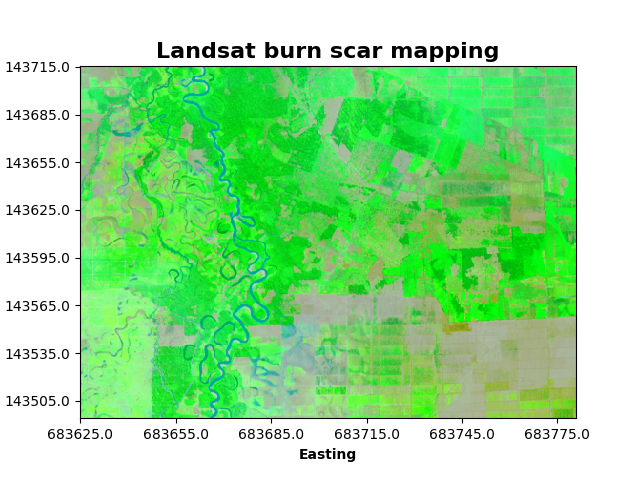

In [31]:
%matplotlib notebook

time = 0
img_toshowNoMask = three_band_image(ds,bands = ['swir2', 'nir', 'red'], time = time)

ax = plt.gca()
ax.set_title("Landsat burn scar mapping", fontweight = 'bold', fontsize = 16)
ax.set_xticklabels(ds.x.values)
ax.set_yticklabels(ds.y.values)
ax.set_xlabel('Easting', fontweight = 'bold')
ax.set_ylabel('Northing', fontweight = 'bold')
plt.imshow(img_toshowNoMask)


Band 7/5 ratios were calculated. This ratio is high for burn scars and low for green vegatation.

<IPython.core.display.Javascript object>


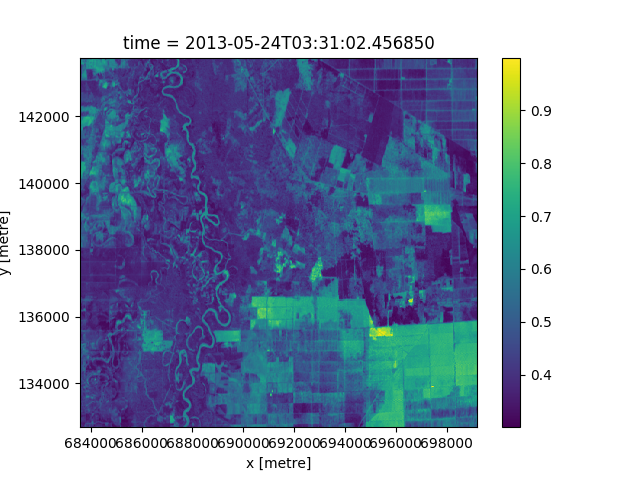

In [20]:
%matplotlib notebook

nir = ds.nir.where(ds.nir != ds.nir.attrs['nodata'])
swir2 = ds.swir2.where(ds.swir2 != ds.swir2.attrs['nodata'])

burn_scar_ratio = ((swir2) / (nir))

burn_scar_ratio_image = burn_scar_ratio.isel(time=0)

burn_scar_ratio_image.plot()